In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
import os
import pandas as pd
import cv2
import torch
import torch.nn as nn
import numpy as np

In [ ]:
!python -m pip install -U setuptools pip

  Using cached setuptools-69.5.1-py3-none-any.whl (894 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet

img_size = (128, 128)
num_classes = 3

transform = transforms.Compose([
              transforms.Resize(img_size),
              transforms.ToTensor(),
              transforms.Normalize((0.485, 0.456, 0.406),
                                   (0.229, 0.224, 0.225))
])

# Label preprocessing
def target_transform(target):
    img = transforms.Resize(img_size)(target)
    img = transforms.functional.pil_to_tensor(img).squeeze_()
    img = img - 1

    img = img.to(torch.long)
    return img


train_set = OxfordIIITPet(root="pets_data", split="trainval", target_types="segmentation",
                             transform=transform,
                             target_transform=target_transform,
                             download=True)

test_set = OxfordIIITPet(root="pets_data", split="test", target_types="segmentation",
                        transform=transform,
                        target_transform=target_transform,
                        download=True)

100%|██████████| 791918971/791918971 [01:14<00:00, 10642854.03it/s]


Extracting pets_data/oxford-iiit-pet/images.tar.gz to pets_data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7322742.20it/s] 


Extracting pets_data/oxford-iiit-pet/annotations.tar.gz to pets_data/oxford-iiit-pet


<class 'torch.Tensor'>


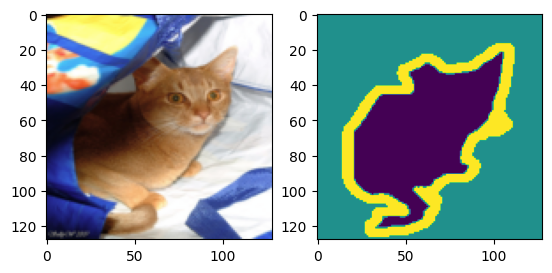

In [ ]:
img=train_set[0][0].numpy().transpose(1,2,0)
mask=train_set[0][1]
print(type(mask))
def de_normalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    result = img * std + mean
    result = np.clip(result, 0.0, 1.0)

    return result

def scale_to_01(image):
    return (image + 1) / 2
img=de_normalize(train_set[0][0].numpy().transpose(1,2,0))

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)


In [ ]:
class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self,x):
        x=self.conv(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels, out_channels, features=[64,128,256,512]):
        super().__init__()
        self.downs=nn.ModuleList()
        self.ups=nn.ModuleList()
        self.Maxpool2d=nn.MaxPool2d(kernel_size=2,stride=2)

        for feature in features:
            self.downs.append(DoubleConv2d(in_channels,feature))
            in_channels=feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(in_channels=feature*2,out_channels=feature,padding=2,stride=2,kernel_size=2)
            )
            self.ups.append(DoubleConv2d(feature*2,feature))

        self.bottom=DoubleConv2d(features[-1],features[-1]*2)
        self.lastConv2d=nn.Conv2d(features[0],out_channels,kernel_size=1)

    def forward(self,x):
        skip_connections=[]
        for down in self.downs:
            x=down(x)
            skip_connections.append(x)
            x=self.Maxpool2d(x)

        x=self.bottom(x)
        skip_connections=skip_connections[::-1]

        for i in range(0,len(self.ups),2):
            x=self.ups[i](x)
            skip_connection=skip_connections[i//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            x=torch.cat((x,skip_connection),dim=1)
            x=self.ups[i+1](x)

        x=self.lastConv2d(x)
        return x


x=torch.rand(1,3,128,128)
model=UNET(in_channels=3,out_channels=3)
model(x).shape

torch.Size([1, 3, 128, 128])

In [ ]:
epochs=10
loss_fn=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)
train_dataloader=DataLoader(train_set,batch_size=64,shuffle=True)
test_dataloader=DataLoader(test_set,batch_size=64,shuffle=True)
model.to("cuda")
for epoch in range(epochs):
  model.train()
  sum_loss=0
  n=len(train_dataloader)
  for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        sum_loss+=loss
  print("Epoch {} : Loss {}".format(epoch+1,sum_loss/n))

Epoch 1 : Loss 0.4635753929615021
Epoch 2 : Loss 0.4096265435218811
Epoch 3 : Loss 0.3834102153778076
Epoch 4 : Loss 0.36442357301712036
Epoch 5 : Loss 0.3450917899608612
Epoch 6 : Loss 0.32918140292167664


KeyboardInterrupt: 